<a href="https://colab.research.google.com/github/iamkaylaliu/cs5330_computer_vision/blob/main/mini_project7_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [1]:
import os
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import files

# Clone the GitHub repository
!git clone https://github.com/iamkaylaliu/cs5330_computer_vision.git

# Set the dataset path directly
dataset_path = 'cs5330_computer_vision/mini-project7/4classes'

# Check if the dataset path exists
if os.path.exists(dataset_path):
    print("Dataset path exists.")
else:
    print("Dataset path does not exist.")

Cloning into 'cs5330_computer_vision'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (406/406), done.
remote: Total 414 (delta 5), reused 411 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (414/414), 32.68 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Dataset path exists.


# Load & Preprocess Images

In [2]:
# Grab all image paths in the input dataset directory
print("[INFO] loading images...")
imagePaths = glob.glob(os.path.join(dataset_path, "**", "*.jpg"), recursive=True)
data = []
labels = []

# Load and preprocess the images
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))  # Resize to match input size for MobileNetV2
    image = image.astype("float32") / 255.0
    data.append(image)

    label = imagePath.split(os.path.sep)[-2]  # Get the label from the folder name
    labels.append(label)

# Encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

[INFO] loading images...


# Build Model (Base: MobileNetV2)

In [3]:
# Perform a training and testing split
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(labels), test_size=0.25)

# Initialize the MobileNetV2 model
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in baseModel.layers:
    layer.trainable = False

# Add custom layers on top
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(len(lb.classes_), activation="softmax")(x)

# Create the model
model = Model(inputs=baseModel.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train Model

In [4]:
# Set up data augmentation
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                                    height_shift_range=0.2, shear_range=0.2,
                                    zoom_range=0.2, horizontal_flip=True,
                                    fill_mode="nearest")

# Fit the model
print("[INFO] training network...")
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(testX, testY),
                    epochs=20, callbacks=[early_stopping])

[INFO] training network...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.3066 - loss: 1.4370 - val_accuracy: 0.5625 - val_loss: 1.0945
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6008 - loss: 0.9981 - val_accuracy: 0.7250 - val_loss: 0.8460
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7156 - loss: 0.8217 - val_accuracy: 0.8375 - val_loss: 0.6485
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8654 - loss: 0.6063 - val_accuracy: 0.8750 - val_loss: 0.5025
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9252 - loss: 0.4409 - val_accuracy: 0.9125 - val_loss: 0.4001
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9452 - loss: 0.3565 - val_accuracy: 0.9375 - val_loss: 0.3245
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9560 - loss: 0.2668 - val_accuracy: 0.9500 - val_loss: 0.2686
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9714 - loss: 0.2176 - val_accuracy: 0.9625 - val_loss: 0.2276
Epoch 9/20
8/8 ━━━━

# Evaluate Model

[INFO] evaluating network...
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
                precision    recall  f1-score   support

    cell_phone       1.00      1.00      1.00        23
remote_control       1.00      0.86      0.92         7
          sofa       1.00      1.00      1.00        23
            tv       0.96      1.00      0.98        27

      accuracy                           0.99        80
     macro avg       0.99      0.96      0.98        80
  weighted avg       0.99      0.99      0.99        80



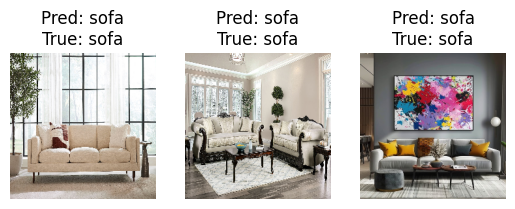

In [5]:
# Evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# Display 3 sample test images with predictions
sample_indices = np.random.choice(len(testX), 3, replace=False)
sample_images = testX[sample_indices]
sample_predictions = predictions[sample_indices]
sample_labels = testY[sample_indices]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(cv2.cvtColor(sample_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {lb.classes_[sample_predictions[i].argmax()]}\nTrue: {lb.classes_[sample_labels[i].argmax()]}")
    plt.axis('off')

plt.show()

# Save Model

In [6]:
# Save the best model
model_save_path = "best_model.keras"  # Specify the model filename
model.save(model_save_path)
print(f"[INFO] model saved to {model_save_path}")

# Download the model to your local machine
# files.download(model_save_path)

[INFO] model saved to best_model.keras
